# Deep Feature Factorizations for better model explainability
![](https://github.com/jacobgil/pytorch-grad-cam/blob/master/examples/dff1.png?raw=true)

In this tutorial we will see how a method called "Deep Feature Factorizations" can be used for creating insightfull visualizations about what the models see inside images.
The pytorch-gradcam package provides an implementation of this method and some additions that make this a very useful tool.

Usually explainability methods answer questions like "Where does the model see a cat in the image" ?

Here instead we will get a much more detailed glimpse into the model, and ask it: 
"Show me all the different concepts you found inside the image, and how are they classified".

We will go over the motivations for this, problems with previous methods, and hopefully get a tool that solves these problems.

## Just show me some code
```python
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_factorization_on_image
dff = DeepFeatureFactorization(model=model, target_layer=model.layer4, computation_on_concepts=model.fc)
concepts, batch_explanations, concept_scores = dff(input_tensor, n_components)
visualization = show_factorization_on_image(rgb_img_float, 
                                            batch_explanations[0],
                                            image_weight=0.3)
```

## Background: what could be improved in methods like Grad-CAM

Most of the explainability methods like Grad-CAM, find an explanation that correspond with a target function.
In the case of classification, the target function is usually the score of one of the categories.

The heatmap is computed in a way that's connected to the network output, with the aim that pixels that get higher values in the attribution, would correspond with a higher output in the target function.

You tell the explainability method: "I want to get a heatmap of the model internal activations that corresponds with the cat category"

In return you get this:

![](https://github.com/jacobgil/pytorch-grad-cam/blob/master/examples/cat.jpg?raw=true)

The different methods use the internal feature representations from the network, so they "open up the black box" and give us a glimpse inside the mechanics of the model. This is great.

But this visualization still leaves some things to be desired:

- **What are the internal concepts the model finds, if any:**

Does the network just see the cat head and body together? Or maybe it detects them as different concepts ?
We heard that neural networks are able to identify high level features like ears, eyes, faces and legs.
But we're never actually able to see this in the model explanations.

- **Could it be that the body of the cat also pulls the output towards other categories as well?**

Just because it contributes to a higher output for one category, it doesn't mean it doesn't contribute to other categories as well.
For example, there are many different types of cats.
To take this into account when we're interpreting the heatmaps, we would have to carefully look at all the heatmaps and keep track of them. 

- **What about the other objects in the image ?**

We typically create a heatmap for a specific category target. In the case of image-net we have 1,000 categories,
so we can't display 1,000 heatmaps or overlay them together, that would be too much information.
Maybe we could detect the top scoring categories for the image and create heatmaps only for them.
But what if one of the objects was detected and then the model just wasn't very confident about it - assigning it a low score relative to the other objects.
We would never know about it.

- **How do we merge all the visualizations into a single image:**
In terms of the visualization itself, if we have 10 heatmaps for 10 categories, we would need to look at 10 different images.
And some of the pixels could get high values in several heatmaps, for example different categories of cats.
This is a lot of information to unpack and not very effecient.

Could we think of a way to create just one visualization that summarizes what the model does for an image ?

## Deep Feature Factorization For Concept Discovery

We will use the ideas in the paper [Deep Feature Factorization For Concept Discovery by Edo Collins, Radhakrishna Achanta, Sabine Süsstrunk](https://arxiv.org/abs/1806.10206) from 2018.

The idea is to factorize the activations from the model into different concepts using Non Negative Matrix Factorization (or from now on- NMF), and for every pixel compute how it corresponds with each of the concepts: 

- Turn the small 2D images in activations into 1D vectors, by reshaping the activations from a tensor of shape Batch, Channels, Height , Width,
to a tensor with the shape Channels x (Batch x Height x Width)
   *Reminder: the activations are typcically non-negative since they are often after a ReLU gate.*


- Compute the NMF of V, for some number of components N.
  
  This gives us V = WH.

  W is a matrix with the shape channels x N.
  
  H is a matrix with the shape N x (Batch x Height x Width).


- W can be thought of as the feature representations of the detected concepts.


- H (after reshaping it back to 2D activations) contains how the pixels corresponds with the different concepts.

If we input a batch of several images, concepts that repeat across the images will be computed.
This gives us a way of automatically discovering concepts in a dataset, and performing tasks like co-localization, further detailed in the paper.

However for our purposes now we will use a batch size of 1: we just want to detect the concepts detected in a single image.

## How do we connect these concepts with the output of the network ?

If we use the activations from the last convolutional layer, just before they are transformerd to a 1D vector (for example by averaging) in a network like Resnet50 for example,
we could just run the remaining part of the network on the concepts and classify each concept.
In resnet50 this would mean just running the fully connected layer, model.fc, on the concepts, which is quite simple.

If we're using the activations from an earlier layer, it's a bit less trivial.
One way could be potentially to unpack the concepts to 2D tensors by duplicating them every pixel.
Another way would be to use only the concept heatmaps but the not the concept embeddings: we could follow the approach of [this tutorial](https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/CAM%20Metrics%20And%20Tuning%20Tutorial.ipynb), ablate the pixels in the heatmap for example by blurring them, and see how the network output chagnes.
If one of the concept heatmap causes a large drop in the cat category score when we blur it - it means it's connected with the cat category.

But we're in luck here - using the last CNN layer is the most common way for creating the model explanations.

## How can we pack the concepts to create a single visualization
We can assign a different color for every concept, and modulate the intensity based on the heatmap.
Then since we have unique colors, we can combine all the masks back into a single image.
But we have a problem - the same pixel can have non zero values from different concepts.
The strategy we will use here will be just to keep the concept that got a higher value in the normalized heatmap, meaning it's more important for it.

For every concept we will also show a legend with informative properties of that concept: the categories that they score highest for.


To get started, let's load our model, and prepare input tensors.

In [28]:
import warnings

warnings.filterwarnings("ignore")
from PIL import Image
import numpy as np
import requests
import cv2
import json
import torch
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    preprocess_image,
    deprocess_image,
)
from pytorch_grad_cam import GradCAM
from torchvision.models import resnet50


def get_image_from_url(url):
    """A function that gets a URL of an image,
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model"""

    # img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.imread(url)
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(
        rgb_img_float, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    return img, rgb_img_float, input_tensor


def create_labels(concept_scores, top_k=2):
    """Create a list with the image-net category names of the top scoring categories"""
    imagenet_categories_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
    labels = eval(requests.get(imagenet_categories_url).text)
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    concept_labels_topk = []
    # for concept_index in range(concept_categories.shape[0]):
    #     categories = concept_categories[concept_index, :]
    #     concept_labels = []
    #     for category in categories:
    #         score = concept_scores[concept_index, category]
    #         label = f"{labels[category].split(',')[0]}:{score:.2f}"
    #         concept_labels.append(label)
    #     concept_labels_topk.append("\n".join(concept_labels))
    return [str(i) for i in range(1310)]  # concept_labels_topk


model = resnet50(pretrained=True)
model.eval()
print("Loaded model")

Loaded model


Now we can just run the DeepFeatureFactorization method on an image using a DeepFeatureFactorization object, then visualize them on top of the image with show_factorization_on_image:

In [29]:
from pytorch_grad_cam.utils.image import show_factorization_on_image


def visualize_image(model, img_url, n_components=5, top_k=2):
    img, rgb_img_float, input_tensor = get_image_from_url(img_url)
    classifier = model.fc
    dff = DeepFeatureFactorization(
        model=model, target_layer=model.inception5b, computation_on_concepts=classifier
    )
    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components)

    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), axis=-1).numpy()
    concept_label_strings = create_labels(concept_outputs, top_k=top_k)
    visualization = show_factorization_on_image(
        rgb_img_float, batch_explanations[0], image_weight=0.3, concept_labels=concepts
    )

    result = np.hstack((img, visualization))

    # Just for the jupyter notebook, so the large images won't weight a lot:
    # if result.shape[0] > 500:
    #     result = cv2.resize(result, (result.shape[1]//4, result.shape[0]//4))

    return result

In [30]:
import torch

model = torch.load("models/googlenet_1_final_11.pt").to("cpu")

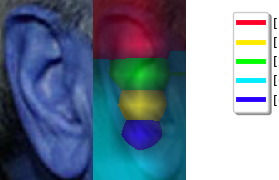

In [34]:
display(Image.fromarray(visualize_image(model, "002.png")))
# display(Image.fromarray(visualize_image(model,
#                                         "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/tutorials/puppies.jpg")))
# display(Image.fromarray(visualize_image(model,
#                                         "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0")))

In [33]:
display(
    Image.fromarray(
        visualize_image(
            model,
            "https://github.com/jacobgil/pytorch-grad-cam/blob/master/examples/both.png?raw=true",
        )
    )
)
display(
    Image.fromarray(
        visualize_image(
            model,
            "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/tutorials/puppies.jpg",
        )
    )
)
display(
    Image.fromarray(
        visualize_image(
            model,
            "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0",
        )
    )
)

TypeError: pic should be PIL Image or ndarray. Got <class 'numpy.float64'>

Notice how we get a separation between different concepts even inside the same object. 

For example in the first image, the head and the body of dog and cat are seperate.

In the second image we get a separation between the faces and the bodies of the puppies.

There is a trade-off here with the number of components N.

If we chose it to be too small, different concepts will be merged together:

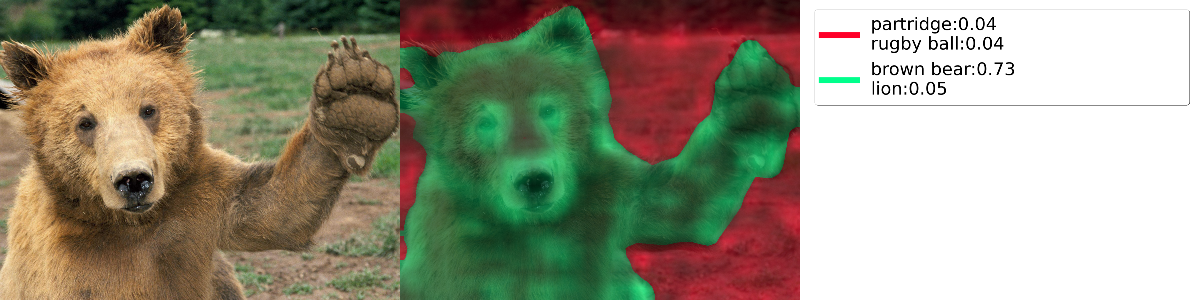

In [35]:
display(
    Image.fromarray(
        visualize_image(
            model,
            "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0",
            n_components=2,
        )
    )
)

If we chose it to be too large, we will get an over-segmentation, with too many esoteric concepts, making it difficult to follow.

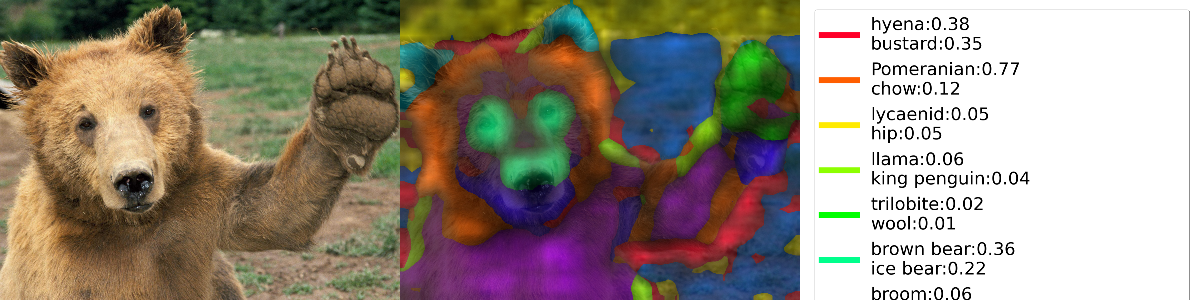

In [37]:
display(
    Image.fromarray(
        visualize_image(
            model,
            "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0",
            n_components=10,
        )
    )
)